# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [46]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
!pip install sagemaker boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
import boto3
import os
import pickle
import numpy as np
from PIL import Image
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [48]:
# Command to download and unzip data
!wget --no-check-certificate https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvf cifar-100-python.tar.gz

--2024-12-14 11:58:36--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.1’

           cifar-10  47%[========>           ]  77.17M  1.71MB/s    eta 50s    ^C
cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
^C


In [49]:
# Transfer Cifer Train data to image
os.makedirs('./train', exist_ok=True)
with open('./cifar-100-python/train', 'rb') as raw_data:
    train_dict = pickle.load(raw_data, encoding='bytes')
    images= train_dict[b'data']
    filenames = train_dict[b'filenames']
    labels = train_dict[b'fine_labels']
    for index, img in enumerate(images):
        img = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0))
        img.save(os.path.join('./train', filenames[index].decode('utf-8')))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # Transfer Cifer Train data to image                                                        │
│    2 os.makedirs('./train', exist_ok=True)                                                       │
│    3 with open('./cifar-100-python/train', 'rb') as raw_data:                                    │
│ ❱  4 │   train_dict = pickle.load(raw_data, encoding='bytes')                                    │
│    5 │   images= train_dict[b'data']                                                             │
│    6 │   filenames = train_dict[b'filenames']                                                    │
│    7 │   labels = train_dict[b'fine_labels']                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
UnpicklingError: pickle data was truncated

In [ ]:
# Transfer Cifer Test data to image
os.makedirs('./test', exist_ok=True)
with open('./cifar-100-python/test', 'rb') as raw_data:
    test_dict = pickle.load(raw_data, encoding='bytes')
    images= test_dict[b'data']
    filenames = test_dict[b'filenames']
    labels = test_dict[b'fine_labels']
    for index, img in enumerate(images):
        img = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0))
        img.save(os.path.join('./test', filenames[index].decode('utf-8')))

In [ ]:
# get role region and bucket info from sagemaker and boto3 
session = sagemaker.Session()
role = get_execution_role()
print(role)
region = boto3.Session().region_name
print(region)
default_bucket = session.default_bucket()
print(default_bucket)

In [ ]:
# calculate the image number under the train and test folder
!echo train image
!ls -1 ./train | wc -l
!echo test image
!ls -1 ./test | wc -l

In [ ]:
# sync file to s3
!aws s3 sync ./train s3://{default_bucket}/train --exclude "*" --include "*.png" --quiet
!aws s3 sync ./test s3://{default_bucket}/test --exclude "*" --include "*.png" --quiet

In [ ]:
# check the file number in each s3 folder
!echo train image in s3 :
!aws s3 ls s3://$default_bucket/train/ --recursive --human-readable --summarize | grep "Total Objects"
!echo test image in s3 :
!aws s3 ls s3://$default_bucket/test/ --recursive --human-readable --summarize | grep "Total Objects"

In [ ]:
# create a train label file and upload to s3
labels = train_dict[b'fine_labels']
filenames = train_dict[b'filenames']
with open('train.txt', 'w') as label_file:
    for filename, label in zip(filenames, labels):
        label_file.write(f"{filename.decode('utf-8')},{label}\n")
!aws s3 cp ./train.txt s3://$default_bucket/train.txt

In [ ]:
# create a test label file and upload to s3
labels = test_dict[b'fine_labels']
filenames = test_dict[b'filenames']
with open('test.txt', 'w') as label_file:
    for filename, label in zip(filenames, labels):
        label_file.write(f"{filename.decode('utf-8')},{label}\n")
!aws s3 cp ./test.txt s3://$default_bucket/test.txt

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": CategoricalParameter([10, 20, 30, 40, 50,60,70,80])
}
metrix=[{'Name': 'validation_accuracy', 'Regex': 'Validation Accuracy: (\S+)'}]

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point='hpo.py',
    role='arn:aws:iam::949492545379:role/mysagemakerrole',
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    output_path='s3://sagemaker-us-east-1-949492545379/output'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name='validation_accuracy',
    metric_definitions=metrix,
    objective_type='Maximize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=1
)
inputs = {
    'train': 's3://sagemaker-us-east-1-949492545379/train/',
    'trainlabel': 's3://sagemaker-us-east-1-949492545379/train.txt',
    'test': 's3://sagemaker-us-east-1-949492545379/test/',
    'testlabel': 's3://sagemaker-us-east-1-949492545379/test.txt'
}

In [9]:
# TODO: Fit your HP Tuner
tuner.fit(inputs) # TODO: Remember to include your data channels
tuner.wait()

[12/15/24 03:23:37] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=880149;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=788866;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[12/15/24 03:23:38] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=520542;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=703285;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=376868;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=472845;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=314735;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=284054;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=787160;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=658348;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=56669;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=227104;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-241215-0323                                                          

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [25]:
# TODO: Get the best estimators and the best HPs
from sagemaker.tuner import HyperparameterTuningJobAnalytics
import pandas as pd

tuning_job_name = tuner.latest_tuning_job.name
df = HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
best_training_job = df.sort_values('FinalObjectiveValue', ascending=False).iloc[0]
best_hyperparameters = {
    "learning_rate": float(best_training_job['learning_rate']),
    "batch_size": int(best_training_job['batch_size'].strip('"')),
    "epochs": int(best_training_job['epochs'].strip('"'))
}

best_estimator = PyTorch(
    entry_point='train_model.py',
    role='arn:aws:iam::949492545379:role/mysagemakerrole',
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters=best_hyperparameters,
    output_path='s3://sagemaker-us-east-1-949492545379/output'
)

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'learning_rate': '0.024225541990991993', 'batch_size': '128', 'epochs': '40'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [103]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs,ProfilerRule
from sagemaker.debugger import DebuggerHookConfig,ProfilerConfig, Profiler,FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.StepOutlier()),
    ProfilerRule.sagemaker(rule_configs.GPUMemoryIncrease()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "50", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

[12/15/24 08:34:45] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=193983;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=211596;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [107]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point='train_model.py',
    role='arn:aws:iam::949492545379:role/mysagemakerrole',
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters=best_hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    output_path='s3://sagemaker-us-east-1-949492545379/output'
)
estimator.fit(inputs)

[12/15/24 08:36:22] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=200300;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=294320;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=399755;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=269559;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[12/15/24 08:36:23] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=841076;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=793041;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=150353;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=610602;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2024-12-15-08-36-22-899                                              

                    ERROR    Please check the troubleshooting guide for common errors:              ]8;id=476320;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=507717;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/session.py#1050\1050]8;;\
                             https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-t                
                             roubleshooting.html#sagemaker-python-sdk-troubleshooting-create-traini                
                             ng-job                                                                                

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 │   profiler_config=profiler_config,                                                        │
│   15 │   output_path='s3://sagemaker-us-east-1-949492545379/output'                              │
│   16 )                                                                                           │
│ ❱ 17 estimator.fit(inputs)                                                                       │
│   18                                                                                             │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/telemetry/telemetry_l │
│ ogging.py:166 in wrapper                                                                         │
│                                                                                                  │
│   163 │   │   │   │   │   caught_ex = e                                                          │
│   164 │   │   │   │   finally:                                                                   │
│   165 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 166 │   │   │   │   │   │   raise caught_ex                                                    │
│   167 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   168 │   │   │   else:                                                                          │
│   169 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/telemetry/telemetry_l │
│ ogging.py:137 in wrapper                                                                         │
│                                                                                                  │
│   134 │   │   │   │   start_timer = perf_counter()                                               │
│   135 │   │   │   │   try:                                                                       │
│   136 │   │   │   │   │   # Call the original function                                           │
│ ❱ 137 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   138 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   139 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   140 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/workflow/pipeline_con │
│ text.py:346 in wrapper                                                                           │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                   

In [91]:
# Download debug data
rule_output_path = estimator.output_path +"/"+ estimator.latest_training_job.job_name + "/debug-output/"
print(rule_output_path)
! aws s3 cp {rule_output_path} ./debug-output/ --recursive --quiet

s3://sagemaker-us-east-1-949492545379/output/pytorch-training-2024-12-15-07-29-46-809/debug-output/


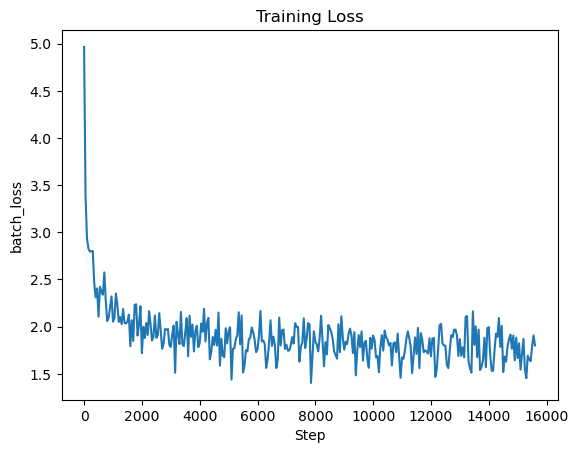

In [106]:
local_path = "./debug-output/"
trial = create_trial(local_path)
batch_loss_tensor = trial.tensor('batch_loss')
steps = batch_loss_tensor.steps()
values = [batch_loss_tensor.value(step) for step in steps]
plt.plot(steps, values)
plt.xlabel('Step')
plt.ylabel('batch_loss')
plt.title('Training Loss')
plt.show()
#print(steps)
#print(values)
#print(trial.tensor_names())

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [94]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path +"/"+ estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)
! aws s3 cp {rule_output_path} ./ --recursive --quiet
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
print(profiler_report_name)
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

s3://sagemaker-us-east-1-949492545379/output/pytorch-training-2024-12-15-07-29-46-809/rule-output
ProfilerReport


## Model Deploying

In [97]:
# Deploy model to an endpoint
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    role='arn:aws:iam::949492545379:role/mysagemakerrole'
)

[12/15/24 08:19:09] INFO     Repacking model artifact                                                  ]8;id=916353;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=386564;file:///root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-949492545379/output/pytorch-training-2024-12-15             
                             -07-54-01-396/output/model.tar.gz), script artifact                                   
                             (s3://sagemaker-us-east-1-949492545379/pytorch-training-2024-12-15-07-54-             
                             01-396/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz             
                             file located at                                                                       
                             s3://sagemaker-us-east-1-949492545379/pytorch-training-2024-12-15-08-19-0             
                             9-717/model.tar.gz. This may take some time depending on model size...                

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Deploy model to an endpoint                                                                │
│ ❱ 2 predictor = estimator.deploy(                                                                │
│   3 │   initial_instance_count=1,                                                                │
│   4 │   instance_type='ml.m5.large',                                                             │
│   5 │   role='arn:aws:iam::949492545379:role/mysagemakerrole'                                    │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/estimator.py:1722 in  │
│ deploy                                                                                           │
│                                                                                                  │
│   1719 │   │   │   inference_tags=format_tags(tags), training_tags=self.tags                     │
│   1720 │   │   )                                                                                 │
│   1721 │   │                                                                                     │
│ ❱ 1722 │   │   return model.deploy(                                                              │
│   1723 │   │   │   instance_type=instance_type,                                                  │
│   1724 │   │   │   initial_instance_count=initial_instance_count,                                │
│   1725 │   │   │   serializer=serializer,                                                        │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/model.py:1725 in      │
│ deploy                                                                                           │
│                                                                                                  │
│   1722 │   │   │   return None                                                                   │
│   1723 │   │                                                                                     │
│   1724 │   │   else:  # existing single model endpoint path                                      │
│ ❱ 1725 │   │   │   self._create_sagemaker_model(                                                 │
│   1726 │   │   │   │   instance_type=instance_type,                                              │
│   1727 │   │   │   │   accelerator_type=accelerator_type,                                        │
│   1728 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /root/miniconda3/envs/jupyterlab_cpu/lib/python3.9/site-packages/sagemaker/model.py:935 in       │
│ _create_sagemaker_model                                                                          │
│                                                                                                  │
│    932 │   │   │   if self.name is None and model_package.name is not None:                      │
│    933 │   │   │   │   self.name = model_package.name                                            │
│    934 │   │   else:                                                                             │
│ ❱  935 │   │   │   container_def = self.prepare_container_def(                                   │
│    936 │   │   │   │   instance_type,                                                            │
│    937 │   │   │   │   accelerator_type=accelerator_type,  

In [ ]:
# TODO: Run an prediction on the endpoint
s3_client = boto3.client('s3')
image_data = (s3_client.get_object(Bucket=bucket_name, Key=object_key))['Body'].read()
image = Image.open(io.BytesIO(image_data)).convert('RGB')
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()